In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import regex as re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from category_encoders import CatBoostEncoder
warnings.filterwarnings("ignore")

Goal of this Notebook:
- Scaling Numeric Columns
- Feature Extraction
- Label Encoding Categorical Columns
- Cleaning Surname Column & Using TF-IDF to vectorize it

In [2]:
# Loading the training data (From the competition as well as the original data)
train = pd.read_csv("Dataset/train.csv")
original = pd.read_csv("Dataset/original.csv")
test = pd.read_csv("Dataset/test.csv") # From the competition to be predicted

train.drop(columns=["id"],inplace=True)
original.drop(columns=['RowNumber'],inplace=True)
test_id = test["id"]
test.drop(columns=["id"],inplace=True)

train = pd.concat([train,original.dropna()],axis=0)
train.reset_index(drop=True,inplace=True)

train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
# Checking Data Types & Checking for Null Values
print(train.dtypes)
print("Null Value: " + str(train.isnull().values.any()))

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object
Null Value: False


In [4]:
scale_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

def scale_data(train, test, column):
    scaler = MinMaxScaler()
    max_value = max(train[column].values.max(), test[column].values.max())
    min_value = min(train[column].values.min(), test[column].values.min())

    train[column] = (train[column] - min_value)/(max_value - min_value)
    test[column] = (test[column] - min_value)/(max_value - min_value)

    return train, test

for column in scale_columns:
    train, test = scale_data(train, test, column)

def FeatureExtraction(df): 
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCategory'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    return df

train = FeatureExtraction(train)
test = FeatureExtraction(test)

In [5]:
# Save these dataframes (processed) for later use
train.to_csv("Dataset/train_processed.csv",index=False)
test.to_csv("Dataset/test_processed.csv",index=False)

In [6]:
Category_Columns = ["Geography", "Gender", "IsSenior", "IsActive_by_CreditCard", "Products_Per_Tenure", "AgeCategory"]

# Label Encoding the Categorical Columns in both the training and testing data
for column in Category_Columns:
    le = LabelEncoder()
    train[column] = le.fit_transform(train[column])
    test[column] = le.transform(test[column])

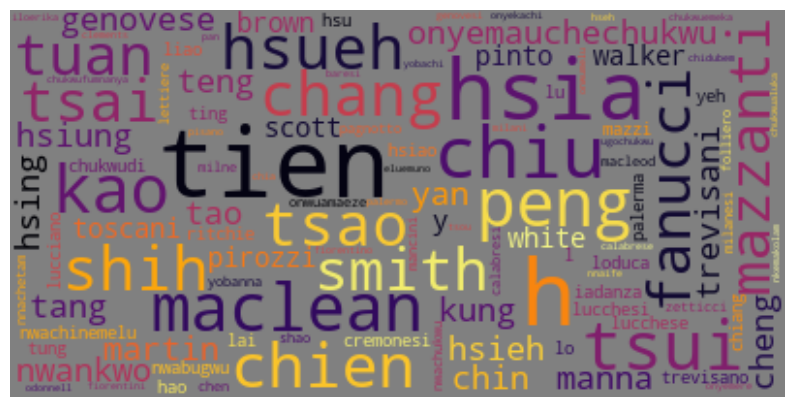

In [7]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', '', text)
    text = text.lower()
    return text.strip()

train['Surname'] = train['Surname'].apply(clean_text)
test['Surname'] = test['Surname'].apply(clean_text)
train['Sur_Geo_Gend_Sal'] = train['Sur_Geo_Gend_Sal'].apply(clean_text)
test['Sur_Geo_Gend_Sal'] = test['Sur_Geo_Gend_Sal'].apply(clean_text)

# Creating a word cloud of the surnames
text = " ".join(train['Surname'])
wordcloud = WordCloud(max_font_size=50, max_words=250, background_color="grey", colormap='inferno').generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
# Using TF-IDF to vectorize the Surname column and then using SVD to reduce the dimensions
vectorizer = TfidfVectorizer(max_features=1000)
vectors_train=vectorizer.fit_transform(train['Surname'])
vectors_test=vectorizer.transform(test['Surname'])

svd = TruncatedSVD(10)
x_pca_train = svd.fit_transform(vectors_train)
x_pca_test = svd.transform(vectors_test)
tfidf_df_train = pd.DataFrame(x_pca_train)
tfidf_df_test = pd.DataFrame(x_pca_test)


cols = [('surname'+"_tfidf_"+str(f)) for f in tfidf_df_train.columns]
tfidf_df_train.columns = cols
tfidf_df_test.columns = cols
train = pd.concat([train,tfidf_df_train], axis="columns")
test = pd.concat([test,tfidf_df_test], axis="columns")

# Using CatBoostEncoder() to encode the Surame column
encoder = CatBoostEncoder()
train['Surname'] = encoder.fit_transform(train['Surname'],train['Exited'])
test['Surname'] = encoder.transform(test['Surname'])

# Using CatBoostEncoder() to encode the Sur_Geo_Gend_Sal column
encoder = CatBoostEncoder()
train['Sur_Geo_Gend_Sal'] = encoder.fit_transform(train['Sur_Geo_Gend_Sal'],train['Exited'])
test['Sur_Geo_Gend_Sal'] = encoder.transform(test['Sur_Geo_Gend_Sal'])

train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,surname_tfidf_0,surname_tfidf_1,surname_tfidf_2,surname_tfidf_3,surname_tfidf_4,surname_tfidf_5,surname_tfidf_6,surname_tfidf_7,surname_tfidf_8,surname_tfidf_9
0,15674932,0.211156,0.636,0,1,0.202703,3,0.000000,2,1.0,...,-1.178759e-07,-1.324965e-07,-0.000004,0.000002,-0.000022,0.000009,-7.643776e-07,-0.000005,0.000014,-0.000050
1,15749177,0.211156,0.554,0,1,0.202703,1,0.000000,2,1.0,...,-3.304461e-07,-2.684761e-06,-0.000006,0.000002,0.000009,-0.000003,-5.333043e-06,0.000066,-0.000007,0.000072
2,15694510,0.211156,0.656,0,1,0.297297,10,0.000000,2,1.0,...,-6.034271e-04,-5.051117e-03,-0.008970,-0.010939,-0.025721,-0.017110,2.976825e-02,0.113928,-0.143069,0.849508
3,15741417,0.211156,0.462,0,1,0.216216,2,0.593398,1,1.0,...,2.602763e-04,1.684288e-03,0.000670,0.028794,0.073136,0.025285,9.721051e-01,0.189000,-0.011867,-0.009314
4,15766172,0.211156,0.732,2,1,0.202703,5,0.000000,2,1.0,...,-1.950592e-08,-1.273990e-06,-0.000007,0.000002,-0.000004,-0.000006,-1.934969e-06,-0.000007,0.000004,-0.000025


In [9]:
# Drop the CustomerId column as it is just a unique identifier
train.drop(columns=["CustomerId"],inplace=True)
test.drop(columns=["CustomerId"],inplace=True)

In [10]:
# Saving the new files to be used in the next notebook (Exploratory Data Analysis)
train.to_csv("Dataset_Processed/train_Processed.csv", index=False)

test.insert(0, 'id', test_id)
test.to_csv("Dataset_Processed/test_Processed.csv", index=False)